In [1]:
#%load_ext autoreload
#%autoreload 2

In [2]:
import jax
import os

In [3]:
from sklearn import datasets
import scanpy as sc
import optax
import matplotlib.pyplot as plt
from sklearn import preprocessing as pp
import numpy as np

import ott
import sklearn
import matplotlib.pyplot as plt
from ott.geometry import geometry, pointcloud
import jax
from typing import Mapping, Any, Optional, Union, Callable, Tuple
from types import MappingProxyType
import jax.numpy as jnp
from functools import partial
from ott.solvers.linear import sinkhorn
from ott.problems.linear import linear_problem
from entot.models.model import OTFlowMatching
from entot.nets.nets import MLP_vector_field, MLP_bridge, MLP_marginal,MLP_fused_vector_field
import sklearn.preprocessing as pp
import scanpy as sc
from ott.solvers.linear import sinkhorn, acceleration
from sklearn import preprocessing as pp

/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/equinox/_ad.py:753: UserWarning: As of Equinox 0.10.7, `equinox.filter_custom_vjp.defvjp` is deprecated in favour of `.def_fwd` and `.def_bwd`. This new API supports symbolic zeros, which allow for more efficient autodifferentiation rules. In particular:
- the fwd and bwd functions take an extra `perturbed` argument, which     indicates which primals actually need a gradient. You can use this     to skip computing the gradient for any unperturbed value. (You can     also safely just ignore this if you wish.)
- `None` was previously passed to indicate a symbolic zero gradient for     all objects that weren't inexact arrays, but all inexact arrays     always had an array-valued gradient. Now, `None` may also be passed     to indicate that an inexact array has a symbolic zero gradient.
  warnings.warn(
2023-09-13 10:48:06.136774: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not 

In [4]:
adata_atac = sc.read("../../data/bone_marrow_atac.h5ad")
adata_rna = sc.read("../../data/bone_marrow_rna.h5ad")

/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


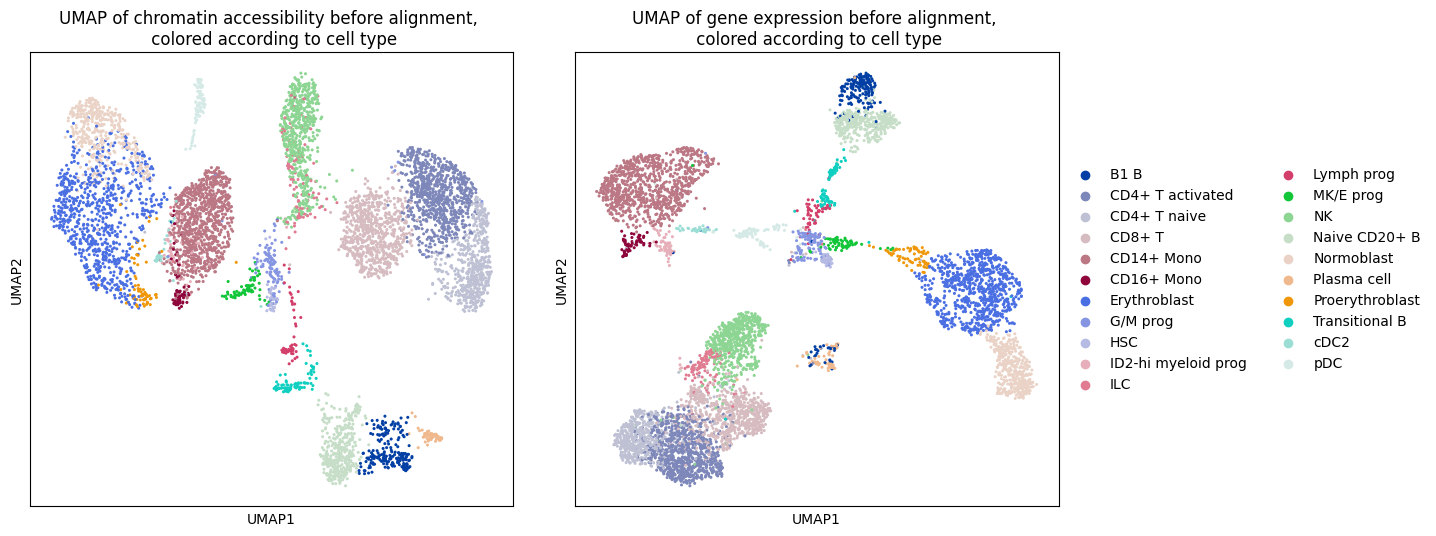

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
sc.pl.umap(adata_atac, color="cell_type", ax=ax1, show=False)
ax1.legend().remove()
ax1.set_title(
    "UMAP of chromatin accessibility before alignment, \n colored according to cell type"
)
sc.pl.umap(adata_rna, color="cell_type", ax=ax2, show=False)
ax2.set_title(
    "UMAP of gene expression before alignment, \n colored according to cell type"
)
plt.tight_layout(pad=3.0)
plt.show()

In [6]:
adata_atac.obsm["ATAC_lsi_l2_norm"] = pp.normalize(
    adata_atac.obsm["ATAC_lsi_red"], norm="l2"
)

In [7]:
adata_rna_red = adata_rna[~adata_rna.obs["cell_type"].isin(["Proerythroblast", "Normoblast", "Erythroblast"])].copy()

In [8]:
source_q = adata_atac.obsm["ATAC_lsi_l2_norm"]
target_q = adata_rna_red.obsm["GEX_X_pca"]

source_fused = adata_atac.obsm["geneactivity_scvi"]
target_fused = adata_rna_red.obsm["geneactivity_scvi"]

In [9]:
source = np.concatenate((source_fused, source_q), axis=1)
target = np.concatenate((target_fused, target_q), axis=1)

In [10]:
neural_net = MLP_vector_field(target.shape[1], latent_embed_dim = 256, num_layers=8, n_frequencies=128)
bridge_net = MLP_bridge(target.shape[1], 1)
linear_ot_solver = sinkhorn.Sinkhorn(
                momentum=acceleration.Momentum(value=1., start=25)
        )
solver = ott.solvers.quadratic.gromov_wasserstein.GromovWasserstein(epsilon=5e-2, linear_ot_solver=linear_ot_solver)


mlp_eta = MLP_marginal(256, 5)
mlp_xi = MLP_marginal(256, 5)

otfm = OTFlowMatching(neural_net, bridge_net, epsilon=None, mlp_eta=mlp_eta, mlp_xi=mlp_xi, tau_a=0.95, tau_b=1.0, scale_cost="mean", input_dim=source.shape[1], output_dim=target.shape[1], iterations=10_000, ot_solver=solver, k_noise_per_x=1, fused_penalty = 0.43, split_dim=source_fused.shape[1])

2023-09-13 10:48:11.648237: W external/xla/xla/service/gpu/nvptx_compiler.cc:698] The NVIDIA driver's CUDA version is 12.1 which is older than the ptxas CUDA version (12.2.128). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [24]:
otfm.iterations=15_000
otfm(source, target, 1024, 1024)

100%|██████████| 15000/15000 [07:50<00:00, 31.89it/s]


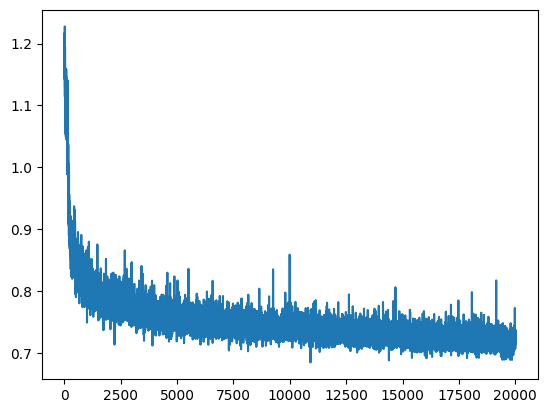

In [25]:
plt.plot(np.arange(len(otfm.metrics["loss"])), otfm.metrics["loss"])

In [26]:
import scipy
def foscttm(
    x: np.ndarray,
    y: np.ndarray,
) -> float:
    d = scipy.spatial.distance_matrix(x, y)
    foscttm_x = (d < np.expand_dims(np.diag(d), axis=1)).mean(axis=1)
    foscttm_y = (d < np.expand_dims(np.diag(d), axis=0)).mean(axis=0)
    fracs = []
    for i in range(len(foscttm_x)):
        fracs.append((foscttm_x[i] + foscttm_y[i]) / 2)
    return np.mean(fracs).round(4)

In [27]:

res = [None] * 10

for i in range(10):
    res[i] = otfm.transport(source, seed=i)[0][0,...]

gex_predicted = jnp.mean(np.asarray(res), axis=0)

In [28]:
foscttm(gex_predicted[~adata_atac.obs["cell_type"].isin(["Proerythroblast", "Normoblast", "Erythroblast"]).values], target)

0.1432

In [29]:
adata_atac.obs["left_marginals"] = otfm.state_eta.apply_fn({"params": otfm.state_eta.params}, x=source)
adata_rna_red.obs["right_marginals"] = otfm.state_xi.apply_fn({"params": otfm.state_xi.params}, x=target)

#lm = otfm.state_eta.apply_fn({"params": otfm.state_eta.params}, x=source)
#lms = np.zeros((len(adata),1))
#lms[:] = None
#lms[adata.obs["batch"] == "ATAC (translated)"] = lm
#adata.obs["left_marginals"] = lms
#rm = otfm.state_xi.apply_fn({"params": otfm.state_xi.params}, x=target)
#rms = np.zeros((len(adata),1))
#rms[:] = None
#rms[adata.obs["batch"] == "RNA"] = rm
#adata.obs["right_marginals"] = rms

In [33]:
def create_helper_col(x):
    if x["cell_type"] in ["Normoblast", "Erythroblast", "Proerythroblast"]:
        return x["cell_type"]
    return "other"
    
adata_atac.obs["helper"] = adata_atac.obs.apply(create_helper_col, axis=1)

In [34]:
adata_atac.obs[["helper", "left_marginals"]].groupby("helper").agg(["mean", "var"])

left_marginals          
                          mean       var
helper                                  
Erythroblast          0.936401  0.001354
Normoblast            0.898308  0.001147
Proerythroblast       0.985747  0.000511
other                 1.017814  0.002075

In [30]:
adata_atac.obs[["cell_type", "left_marginals"]].groupby("cell_type").mean().sort_values("left_marginals")

,left_marginals
cell_type,
Normoblast,0.898308
Erythroblast,0.936401
NK,0.979174
Plasma cell,0.979833
ILC,0.980398
B1 B,0.982603
Transitional B,0.983717
Naive CD20+ B,0.985023
Proerythroblast,0.985747


In [32]:
adata_rna_red.obs[["cell_type", "right_marginals"]].groupby("cell_type").mean().sort_values("right_marginals")

,right_marginals
cell_type,
ID2-hi myeloid prog,0.998272
pDC,0.998399
CD16+ Mono,0.998416
cDC2,0.998416
NK,0.998474
CD8+ T,0.998481
ILC,0.998508
Naive CD20+ B,0.998531
HSC,0.998554


In [ ]:
adata[adata.obs["batch"] == "ATAC (translated)"].obs[["cell_type", "left_marginals"]].groupby("cell_type").mean()

In [46]:
adata[adata.obs["batch"] == "RNA"].obs[["cell_type", "right_marginals"]].groupby("cell_type").mean()

,right_marginals
cell_type,
B1 B,0.997913
CD4+ T activated,0.997915
CD4+ T naive,0.998136
CD8+ T,0.997337
CD14+ Mono,0.997973
CD16+ Mono,0.997218
Erythroblast,1.011610
G/M prog,0.996859
HSC,0.996724


/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


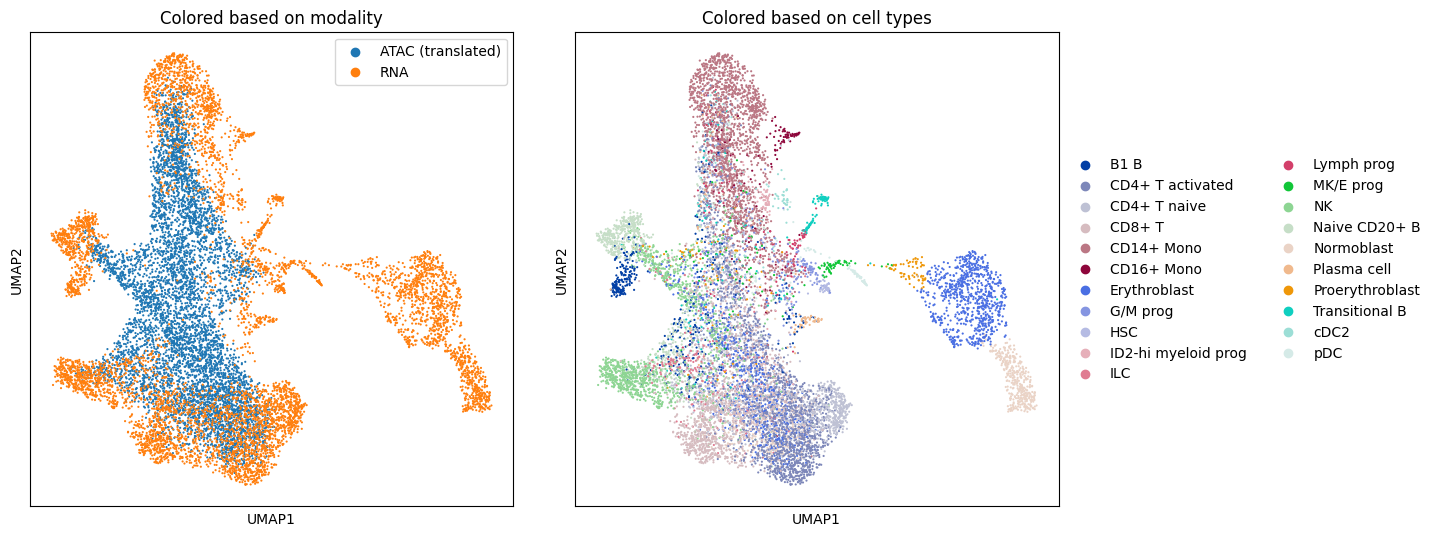

In [31]:
import scanpy as sc
adata = sc.concat(
    [adata_atac, adata_rna],
    join="outer",
    label="batch",
    keys=["ATAC (translated)", "RNA"],
)
adata.obsm["X_translated_1"] = np.concatenate(
    (gex_predicted[..., 10:], target[..., 10:]), axis=0
)
sc.pp.neighbors(adata, use_rep="X_translated_1")
sc.tl.umap(adata)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
sc.pl.umap(adata, color=["batch"], ax=ax1, show=False)
ax1.legend()
ax1.set_title("Colored based on modality")
sc.pl.umap(adata, color=["cell_type"], ax=ax2, show=False)
ax2.set_title("Colored based on cell types")
plt.tight_layout(pad=3.0)
plt.show()

/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


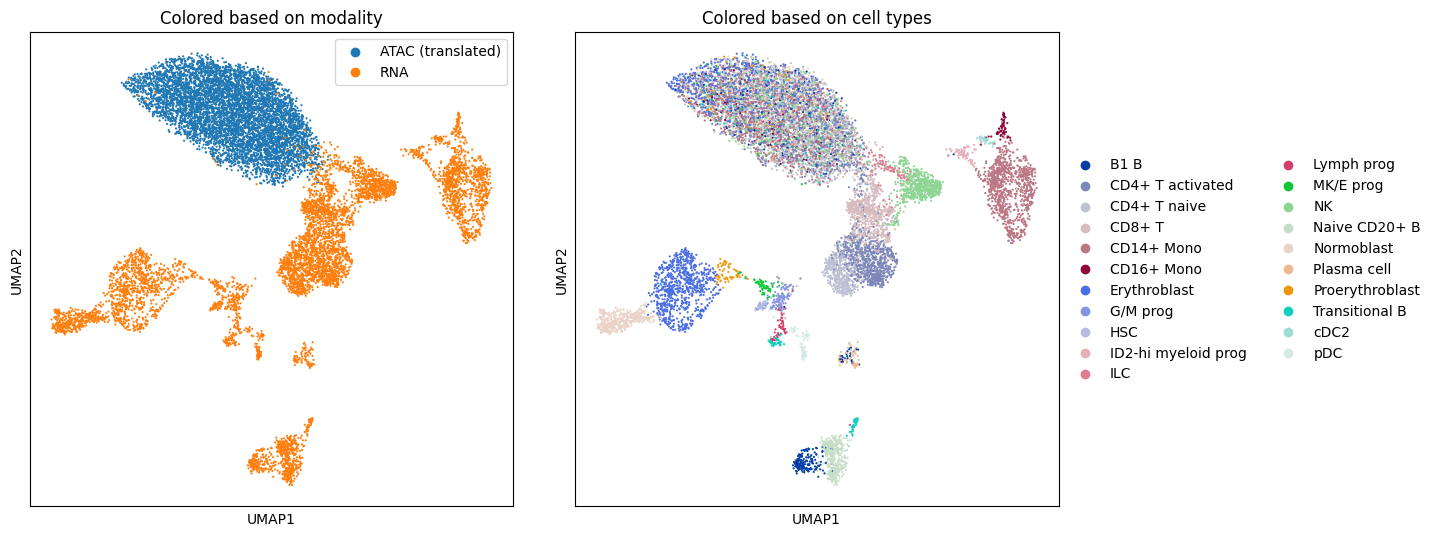

In [23]:
import scanpy as sc
adata = sc.concat(
    [adata_atac, adata_rna],
    join="outer",
    label="batch",
    keys=["ATAC (translated)", "RNA"],
)
adata.obsm["X_translated_1"] = np.concatenate(
    (gex_predicted, target), axis=0
)
sc.pp.neighbors(adata, use_rep="X_translated_1")
sc.tl.umap(adata)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
sc.pl.umap(adata, color=["batch"], ax=ax1, show=False)
ax1.legend()
ax1.set_title("Colored based on modality")
sc.pl.umap(adata, color=["cell_type"], ax=ax2, show=False)
ax2.set_title("Colored based on cell types")
plt.tight_layout(pad=3.0)
plt.show()

/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


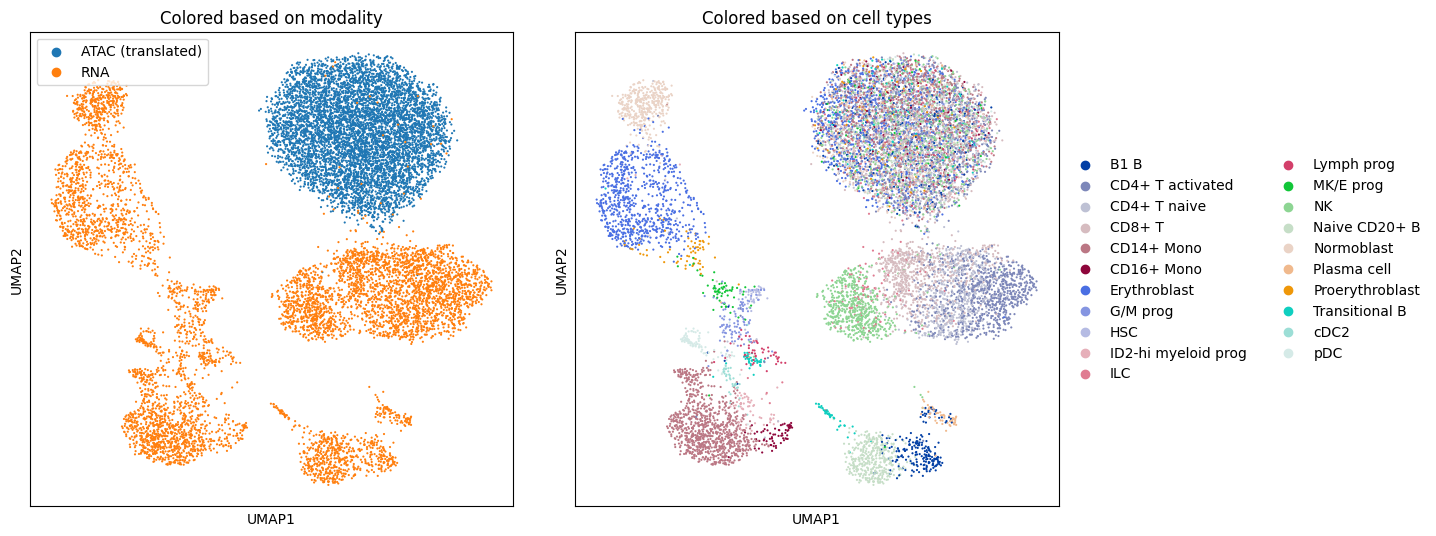

In [24]:
import scanpy as sc
adata = sc.concat(
    [adata_atac, adata_rna],
    join="outer",
    label="batch",
    keys=["ATAC (translated)", "RNA"],
)
adata.obsm["X_translated_1"] = np.concatenate(
    (gex_predicted[...,:10], target[...,:10]), axis=0
)
sc.pp.neighbors(adata, use_rep="X_translated_1")
sc.tl.umap(adata)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
sc.pl.umap(adata, color=["batch"], ax=ax1, show=False)
ax1.legend()
ax1.set_title("Colored based on modality")
sc.pl.umap(adata, color=["cell_type"], ax=ax2, show=False)
ax2.set_title("Colored based on cell types")
plt.tight_layout(pad=3.0)
plt.show()

In [16]:
def foscttm(
    x: np.ndarray,
    y: np.ndarray,
) -> float:
    d = scipy.spatial.distance_matrix(x, y)
    foscttm_x = (d < np.expand_dims(np.diag(d), axis=1)).mean(axis=1)
    foscttm_y = (d < np.expand_dims(np.diag(d), axis=0)).mean(axis=0)
    fracs = []
    for i in range(len(foscttm_x)):
        fracs.append((foscttm_x[i] + foscttm_y[i]) / 2)
    return np.mean(fracs).round(4)

In [17]:

res = [None] * 30

for i in range(30):
    res[i] = otfm.transport(source, seed=i)[0][0,...]

In [18]:
res2 = jnp.mean(np.asarray(res), axis=0)

In [19]:
foscttm(res2, target)

NameError: name 'scipy' is not defined

In [ ]:
import scipy 
foscttm(gex_predicted[0,...], target)

In [ ]:
foscttm(gex_predicted[0,...][..., 10:], target[..., 10:])

In [ ]:
foscttm(gex_predicted[0,...][..., :10], target[..., :10])

In [ ]:
foscttm(jnp.mean(gex_predicted, axis=0)[..., 10:], target[..., 10:])

In [ ]:
gex_predicted

In [ ]:
res = [None] * 15

for i in range(15):
    res[i]= otfm.transport(source_concat, seed=i)[0][0,...]

In [ ]:
gex_predicted = jnp.mean(jnp.asarray(res), axis=0)

In [ ]:
foscttm(gex_predicted, target_concat)

In [ ]:
foscttm(gex_predicted[..., 10:], target_concat[..., 10:])

In [ ]:
foscttm(gex_predicted[..., :10], target_concat[..., :10])

In [ ]:
samples = jnp.array(res)
vars = jnp.var(samples, axis=0)
vars_summed = jnp.sum(vars, axis=1)

In [ ]:
fill = np.empty(len(target))[:, None]
fill[:] = np.nan
adata.obs["var"] = np.asarray(np.concatenate((vars_summed[:, None], fill)))

In [ ]:
sc.pl.umap(adata, color="var", vmax="p99")

In [ ]:
adata.obs[["cell_type", "var"]].groupby("cell_type").mean()

In [ ]:
sc.tl.dendrogram(adata, groupby="cell_type")

In [ ]:
sc.pl.dendrogram(adata, groupby="cell_type")

In [ ]:
sc.pl.correlation_matrix(adata, groupby="cell_type")